In [1]:
from satpy import Scene
import satpy
import numpy as np
import datetime as dt
import glob
import subprocess
import pickle
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import time


all_channels = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
                'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16']
my_dat_path = "E:\\RAIKOKE"
my_arr_path = "E:\\RAIKOKE_ARRAYS"
my_model_path = "C:\\Users\\dancu\\Documents\\GitHub\\volcanic_ash_AI\\Models"
feature_radius = 15
n_features = 19

In [44]:
def temperature_rescale(array):
    return (array-200)/100.


def reflectance_rescale(array):
    return array/100.


def get_local_matrix(indx, jndx, array, size):  # returns matrix centred at indx, jndx of size size. cuts off at edge
    array_shape = np.shape(array)
    r1 = indx - size
    r2 = indx + size + 1
    c1 = jndx - size
    c2 = jndx + size + 1
    if r1 < 0:
        r1 = 0
    if c1 < 0:
        c1 = 0
    if r2 > array_shape[0]:
        r2 = array_shape[0] + 1
    if c2 > array_shape[1]:
        c2 = array_shape[1] + 1

    return array[r1:r2,c1:c2]


def get_local_T11_max(i, j, array, radius):
    try:
        return np.nanmax(get_local_matrix(i, j, array, radius))
    except ValueError:
        # print("Value Error Encountered in Calculating Max")
        return array[i, j]


def get_local_T11_variance(i, j, array, radius):  # this actually does std now to improve the spread of values
    try:
        return np.nanstd(get_local_matrix(i, j, array, radius))
    except ValueError:
        # print("Value Error Encountered in Calculating Var")
        return 0.


def generate_command_list(year, month, day, start_time, step, n_scenes, segment, download_dir, auto_download):
    command_base_0 = "aws s3 sync --no-sign-request"
    command_base_1 = "--exclude \"*\" --include "
    command_base_2 = "\"s3://noaa-himawari8/AHI-L1b-FLDK/"
    str_format = '%Y/%m/%d/%H%M'
    command_list = []
    year = str(year)  # 2021
    month = str(month)  # 12
    day = str(day)  # 04
    start_time = str(start_time)  # 0740
    step = int(step)  # 1 = 10 minute step
    n_scenes = int(n_scenes)  # 60 = 10 hours
    segment = str(segment)  # 6
    download_dir = str(download_dir)
    segment_str = f"\"*S{segment.zfill(2)}10*\""
    time_0 = dt.datetime.strptime(year+month+day+start_time, '%Y%m%d%H%M')
    n_minutes = 10
    for i in range(n_scenes):
        command_list.append(f'{command_base_0} {command_base_1}{segment_str} '
                            f'{command_base_2}{dt.datetime.strftime(time_0,str_format)}'
                            f'\" \"{download_dir}\"')
        time_0 += dt.timedelta(minutes=n_minutes*step)
    if auto_download:
        for idx,command in enumerate(command_list):
            subprocess.run(command)
            print(f"Command {command} has been run")
            print(f"Downloaded file {idx + 1} of {len(command_list)}")
    else:
        for command in command_list:
            print(command)


def save_np_array(datpath, outpath, i, r1, r2, c1, c2):
    # make satpy scene out of required himawari8 data
    all_files = glob.glob(f"{datpath}\\*.bz2*") # set this to .dat if you're using .dat files
    # these are hopefully in groups of 16 so I don't actually have to search through dates
    all_datasets = [(all_files[x:x+16]) for x in range(0, int(len(all_files)), 16)]  # set this to 16* the number of segs
    scene = Scene(all_datasets[i], reader="ahi_hsd")

    # load all the data
    scene.load(all_channels)

    # resample our data to the same resolution (2km at subsurface pt)
    lscene = scene.resample(scene.coarsest_area(), resampler='native')
    volc_coords = scene["B14"].attrs["area"].get_xy_from_lonlat(153.25, 48.28)
    print(f"volc_coords {volc_coords}")
    # load in data about the polygon
    square = [r1, r2, c1, c2]

    # load in all the other satellite data (visible and IR bands)
    b01 = lscene['B01'].values[square[0]:square[1], square[2]:square[3]]
    b02 = lscene['B02'].values[square[0]:square[1], square[2]:square[3]]
    b03 = lscene['B03'].values[square[0]:square[1], square[2]:square[3]]
    b04 = lscene['B04'].values[square[0]:square[1], square[2]:square[3]]
    b05 = lscene['B05'].values[square[0]:square[1], square[2]:square[3]]
    b06 = lscene['B06'].values[square[0]:square[1], square[2]:square[3]]
    b07 = lscene['B07'].values[square[0]:square[1], square[2]:square[3]]
    b08 = lscene['B08'].values[square[0]:square[1], square[2]:square[3]]
    b09 = lscene['B09'].values[square[0]:square[1], square[2]:square[3]]
    b10 = lscene['B10'].values[square[0]:square[1], square[2]:square[3]]
    b11 = lscene['B11'].values[square[0]:square[1], square[2]:square[3]]
    b12 = lscene['B12'].values[square[0]:square[1], square[2]:square[3]]
    b13 = lscene['B13'].values[square[0]:square[1], square[2]:square[3]]
    b14 = lscene['B14'].values[square[0]:square[1], square[2]:square[3]]
    b15 = lscene['B15'].values[square[0]:square[1], square[2]:square[3]]
    b16 = lscene['B16'].values[square[0]:square[1], square[2]:square[3]]

    output_array = np.dstack((b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11,
                             b12, b13, b14, b15, b16)).astype(np.float32)

    print("Shape of output_array: " + str(output_array.shape))
    output_filename = f"{outpath}\\{all_datasets[i][0][len(datpath)+8:len(datpath)+21]}.npy"
    np.save(output_filename, output_array)
    print(f"File {i} saved using the files {all_datasets[i]}")


def generate_ash_prediction(array_path, out_path, i, probability, IR, BTD, model_name):
    print(f"Commencing processing of file {i}")
    array_names = glob.glob(f"{array_path}\\*.npy")
    data_array = np.load(array_names[i])
    model = load(f"{my_model_path}\\{model_name}")
    array_size = np.shape(data_array)
    array_y = array_size[0]
    array_x = array_size[1]

    train_data = np.nan_to_num(data_array[:, :, :16])
    train_data_n = np.copy(train_data)

    # rescale everything
    for j in range(0, 6):
        train_data_n[:, :, j] = reflectance_rescale(train_data[:, :, j])
    for j in range(6, 16):
        train_data_n[:, :, j] = temperature_rescale(train_data[:, :, j])
    plt.imshow(train_data_n[:,:,14], cmap="seismic")
    predict_data = np.zeros((array_y, array_x))
    t0 = time.time()
    for a in range(array_y):
        if a%50 == 0:
            print(f"processing row {a}")
        for b in range(array_x):
            empty_data = np.zeros(n_features)
            band_values = train_data_n[a, b, :]
            empty_data[:16] = band_values
            empty_data[16] = np.nan_to_num(get_local_T11_max(a, b, train_data_n[:, :, 14], 2 * feature_radius))
            empty_data[17] = np.nan_to_num(100. * get_local_T11_variance(a, b, train_data_n[:, :, 14], feature_radius))
            empty_data[18] = np.nan_to_num(10. * (train_data_n[a, b, 13] - train_data_n[a, b, 14]))

            classify_vector = empty_data.reshape(1, -1)
            prob = model.predict_proba(classify_vector)
            predict_data[a, b] = prob[0][0]
    t1 = time.time()
    delt = t1 - t0
    print("Time taken: " + str(np.round(delt, 2)) + "s")
    d_len = len(array_path)
    file_tag = array_names[i][2+d_len:]

    # predict_data[0,0] = 1.0  # this is for scaling purposes
    # predict_data[-1,-1] = 0.0
    if probability:

        plt.imsave(out_path + "\\predict_proba_" + str(i) + "_" + str(file_tag)
                   + "_random_forest" + "_.png", predict_data, cmap="seismic")

    if IR:

        plt.imsave(out_path + "\\IR_" + str(i) + "_" + str(file_tag) + ".png",
                   train_data_n[:, :, 14], cmap="binary")

    if BTD:

        plt.imsave(out_path + "\\BTD_" + str(i) + "_" + str(file_tag) + ".png",
                   train_data[:, :, 13] - train_data[:, :, 14], cmap="seismic")

def plot_BTD(array_path, out_path, i, ch_1, ch_2):
    print(f"Commencing processing of file {i}")
    array_names = glob.glob(f"{array_path}\\*.npy")
    data_array = np.load(array_names[i])
    data = np.nan_to_num(data_array[:, :, :16])
    d_len = len(array_path)
    file_tag = array_names[i][2+d_len:]
    out_name = f"BTD_{ch_1}-{ch_2}_{file_tag}.png"
    plt.imsave(f"{out_path}_{out_name}",data[:,:,ch_1]-data[:,:,ch_2], cmap = "PiYG")

def main():
    # generate_command_list("2020","07","06","0520",1,60,3,"D:\\NISHINOSHIMA_DATA",True)
    # save_np_array(my_dat_path, my_arr_path, 0, 400, 600, 3100, 3400)
    for h in range(1):
        generate_ash_prediction(my_arr_path, "E:\\RAIKOKE_ARRAYS", h, True, True, True, "RF_2_ratio_6.sav")

Commencing processing of file 0
processing row 0


D:\Miniconda\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Miniconda\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Miniconda\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Miniconda\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Miniconda\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Miniconda\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var 

KeyboardInterrupt: 

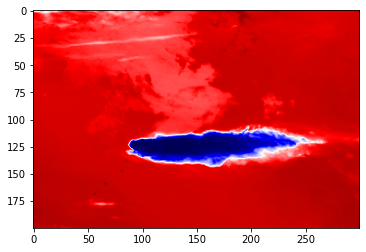

In [3]:
if __name__ == "__main__":
    main()



In [5]:
probability = True
IR = True
BTD = True
print(f"Commencing processing of file {0}")
array_names = glob.glob("E:\\RAIKOKE_ARRAYS\\*.npy")
data_array = np.load(array_names[0])
model = load("C:\\Users\\dancu\\Documents\\GitHub\\volcanic_ash_AI\\Models\\RF_2_ratio_6.sav")
array_size = np.shape(data_array)
array_y = array_size[0]
array_x = array_size[1]

train_data = np.nan_to_num(data_array[:, :, :16])
train_data_n = np.copy(train_data)

Commencing processing of file 0


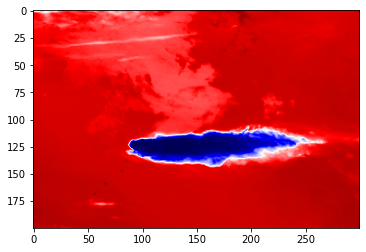

In [6]:
# rescale everything
for j in range(0, 6):
    train_data_n[:, :, j] = reflectance_rescale(train_data[:, :, j])
for j in range(6, 16):
    train_data_n[:, :, j] = temperature_rescale(train_data[:, :, j])
plt.imshow(train_data_n[:,:,14], cmap="seismic")
predict_data = np.zeros((array_y, array_x))
t0 = time.time()

In [42]:
my_test = train_data_n[:,:,14]
my_local_test = get_local_matrix(0,0,train_data_n[:,:,14],feature_radius)
my_variance_test = get_local_T11_variance(0,0,train_data_n[:,:,14], 2 * feature_radius)

array_shape = (200, 300)
array_shape = (200, 300)


In [45]:
for a in range(array_y):
    if a%50 == 0:
        print(f"processing row {a}")
    for b in range(array_x):
        empty_data = np.zeros(n_features)
        band_values = train_data_n[a, b, :]
        empty_data[:16] = band_values
        empty_data[16] = np.nan_to_num(get_local_T11_max(a, b, train_data_n[:, :, 14], 2 * feature_radius))
        empty_data[17] = np.nan_to_num(100. * get_local_T11_variance(a, b, train_data_n[:, :, 14], feature_radius))
        empty_data[18] = np.nan_to_num(10. * (train_data_n[a, b, 13] - train_data_n[a, b, 14]))

        classify_vector = empty_data.reshape(1, -1)
        prob = model.predict_proba(classify_vector)
        predict_data[a, b] = prob[0][0]



processing row 0
processing row 50
processing row 100
processing row 150


In [46]:
t1 = time.time()
delt = t1 - t0
print("Time taken: " + str(np.round(delt, 2)) + "s")
d_len = len("E:\\RAIKOKE_ARRAYS")
file_tag = array_names[0][2+d_len:]

# predict_data[0,0] = 1.0  # this is for scaling purposes
# predict_data[-1,-1] = 0.0
if probability:

    plt.imsave("E:\\RAIKOKE_ARRAYS" + "\\predict_proba_" + str(0) + "_" + str(file_tag)
               + "_random_forest" + "_.png", predict_data, cmap="seismic")

if IR:

    plt.imsave("E:\\RAIKOKE_ARRAYS" + "\\IR_" + str(0) + "_" + str(file_tag) + ".png",
               train_data_n[:, :, 14], cmap="binary")

if BTD:

    plt.imsave("E:\\RAIKOKE_ARRAYS" + "\\BTD_" + str(0) + "_" + str(file_tag) + ".png",
               train_data[:, :, 13] - train_data[:, :, 14], cmap="seismic")

Time taken: 5762.81s
